# mock项目

### 1、导入数据处理和建立模型所需的包

In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import roc_auc_score,recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC 
import matplotlib.pyplot as plt

### 2、基本数据查看

In [2]:
# 导入数据集
data = pd.read_csv('./data.csv')
# 查看数据情况
data.head(5)
# 查看列情况
data.columns
# 查看数据维度
data.shape

(5000, 1281)

### 3、数据探索

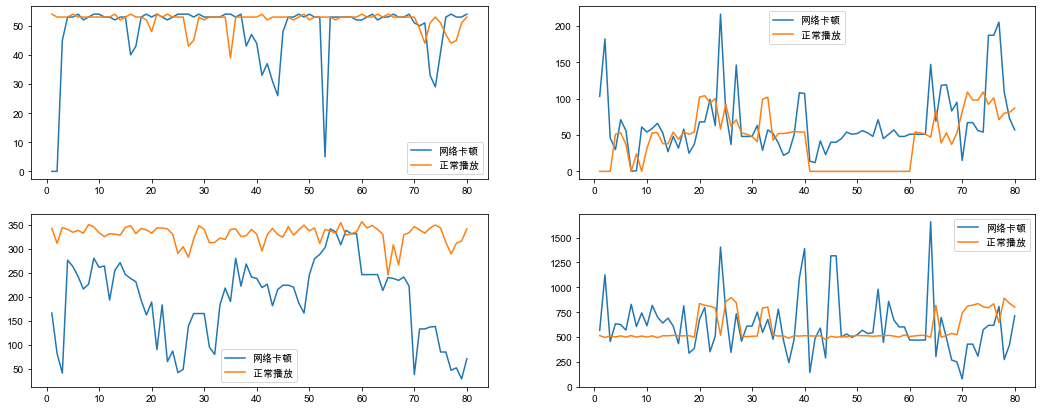

In [3]:
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
txAudioKBitrate_2 = pd.concat([data.loc[data['type'] == 2, ['txAudioKBitrate_lead_'+str(i) for i in range(1, 41)]],
          data.loc[data['type'] == 2, ['txAudioKBitrate_lag_'+str(i) for i in range(1, 41)]]], axis = 1)
txAudioKBitrate_0 = pd.concat([data.loc[data['type'] == 0, ['txAudioKBitrate_lead_'+str(i) for i in range(1, 41)]],
          data.loc[data['type'] == 0, ['txAudioKBitrate_lag_'+str(i) for i in range(1, 41)]]], axis = 1)

rxAudioKBitrate_2 = pd.concat([data.loc[data['type'] == 2, ['rxAudioKBitrate_lead_'+str(i) for i in range(1, 41)]],
          data.loc[data['type'] == 2, ['rxAudioKBitrate_lag_'+str(i) for i in range(1, 41)]]], axis = 1)
rxAudioKBitrate_0 = pd.concat([data.loc[data['type'] == 0, ['rxAudioKBitrate_lead_'+str(i) for i in range(1, 41)]],
          data.loc[data['type'] == 0, ['rxAudioKBitrate_lag_'+str(i) for i in range(1, 41)]]], axis = 1)

txVideoKBitrate_2 = pd.concat([data.loc[data['type'] == 2, ['txVideoKBitrate_lead_'+str(i) for i in range(1, 41)]],
          data.loc[data['type'] == 2, ['txVideoKBitrate_lag_'+str(i) for i in range(1, 41)]]], axis = 1)
txVideoKBitrate_0 = pd.concat([data.loc[data['type'] == 0, ['txVideoKBitrate_lead_'+str(i) for i in range(1, 41)]],
          data.loc[data['type'] == 0, ['txVideoKBitrate_lag_'+str(i) for i in range(1, 41)]]], axis = 1)

rxVideoKBitrate_2 = pd.concat([data.loc[data['type'] == 2, ['rxVideoKBitrate_lead_'+str(i) for i in range(1, 41)]],
          data.loc[data['type'] == 2, ['rxVideoKBitrate_lag_'+str(i) for i in range(1, 41)]]], axis = 1)
rxVideoKBitrate_0 = pd.concat([data.loc[data['type'] == 0, ['rxVideoKBitrate_lead_'+str(i) for i in range(1, 41)]],
          data.loc[data['type'] == 0, ['rxVideoKBitrate_lag_'+str(i) for i in range(1, 41)]]], axis = 1)

fig,ax=plt.subplots(2,2)
fig.set_size_inches(18, 7)
ax[0][0].plot(range(1, 81), txAudioKBitrate_2.iloc[1,:])
ax[0][0].plot(range(1, 81), txAudioKBitrate_0.iloc[1,:])
ax[0][0].legend(['网络卡顿','正常播放'])
ax[0][1].plot(range(1, 81), rxAudioKBitrate_2.iloc[2,:])
ax[0][1].plot(range(1, 81), rxAudioKBitrate_0.iloc[2,:])
ax[0][1].legend(['网络卡顿','正常播放'])
ax[1][0].plot(range(1, 81), txVideoKBitrate_2.iloc[2,:])
ax[1][0].plot(range(1, 81), txVideoKBitrate_0.iloc[2,:])
ax[1][0].legend(['网络卡顿','正常播放'])
ax[1][1].plot(range(1, 81), rxVideoKBitrate_2.iloc[2,:])
ax[1][1].plot(range(1, 81), rxVideoKBitrate_0.iloc[2,:])
ax[1][1].legend(['网络卡顿','正常播放'])

# 总结：
- 基于上面对四个特征维度的可视化可以看出正常播放的各维度的值的变化相对来说比较平缓 
- 网络卡顿的值的变化比较大

### 4、数据预处理
- 删除不重要的特征 sentFrameRate and sentBitrate
- 缺失值处理：均值填补
- 特征选择：为了减少特征维度以及根据可视化情况 将工单提交前后的80次特征数据取均值作为新特征
- 标签处理：将标签为正常播放和轻微抖动不影响上课的标签标记为正常数据0 网络卡顿的标签标记为非正常1
- 样本不平衡的问题
- 数据标准化

In [4]:
# 删除不重要的特征列 - sentFrameRate and sentBitrate
for i in range(1, 41):
    data = data.drop(data.loc[:, ['sentFrameRate_lead_' + str(i)]], axis = 1)
    data = data.drop(data.loc[:, ['sentFrameRate_lag_' + str(i)]], axis = 1)
    data = data.drop(data.loc[:, ['sentBitrate_lead_' + str(i)]], axis = 1)
    data = data.drop(data.loc[:, ['sentBitrate_lag_' + str(i)]], axis = 1)
data.shape

(5000, 1121)

In [5]:
# 处理缺失值-用均值填补缺失值
data = data.fillna(-999) # 将含有空值的统一替换成-999在进行缺失值处理
si = SimpleImputer(missing_values = -999, strategy = 'mean')
si.fit(data.iloc[:, 1:])

data.iloc[:, 1:] = si.transform(data.iloc[:, 1:])

In [6]:
# 因为网络卡顿会导致特征数据出现一定的浮动所以这里选择将工单提交前后的80次特征数据取均值作为新特征
# 也是为了减少特征维度  当前维度一共有1120个特征 维度过高
data_duration = pd.concat([data.loc[:, ['duration_lead_'+str(i) for i in range(1, 41)]],
          data.loc[:, ['duration_lag_'+str(i) for i in range(1, 41)]]], axis = 1)
data_txAudioKBitrate = pd.concat([data.loc[:, ['txAudioKBitrate_lead_'+str(i) for i in range(1, 41)]],
          data.loc[:, ['txAudioKBitrate_lag_'+str(i) for i in range(1, 41)]]], axis = 1)
data_rxAudioKBitrate = pd.concat([data.loc[:, ['rxAudioKBitrate_lead_'+str(i) for i in range(1, 41)]],
          data.loc[:, ['rxAudioKBitrate_lag_'+str(i) for i in range(1, 41)]]], axis = 1)
data_txVideoKBitrate = pd.concat([data.loc[:, ['txVideoKBitrate_lead_'+str(i) for i in range(1, 41)]],
          data.loc[:, ['txVideoKBitrate_lag_'+str(i) for i in range(1, 41)]]], axis = 1)
data_rxVideoKBitrate = pd.concat([data.loc[:, ['rxVideoKBitrate_lead_'+str(i) for i in range(1, 41)]],
          data.loc[:, ['rxVideoKBitrate_lag_'+str(i) for i in range(1, 41)]]], axis = 1)
data_cpuTotalUsage = pd.concat([data.loc[:, ['cpuTotalUsage_lead_'+str(i) for i in range(1, 41)]],
          data.loc[:, ['cpuTotalUsage_lag_'+str(i) for i in range(1, 41)]]], axis = 1)
data_cpuAppUsage = pd.concat([data.loc[:, ['cpuAppUsage_lead_'+str(i) for i in range(1, 41)]],
          data.loc[:, ['cpuAppUsage_lag_'+str(i) for i in range(1, 41)]]], axis = 1)
data_userCount = pd.concat([data.loc[:, ['userCount_lead_'+str(i) for i in range(1, 41)]],
          data.loc[:, ['userCount_lag_'+str(i) for i in range(1, 41)]]], axis = 1)
data_cpu = pd.concat([data.loc[:, ['cpu_lead_'+str(i) for i in range(1, 41)]],
          data.loc[:, ['cpu_lag_'+str(i) for i in range(1, 41)]]], axis = 1)
data_lag = pd.concat([data.loc[:, ['lag_lead_'+str(i) for i in range(1, 41)]],
          data.loc[:, ['lag_lag_'+str(i) for i in range(1, 41)]]], axis = 1)
data_fps = pd.concat([data.loc[:, ['fps_lead_'+str(i) for i in range(1, 41)]],
          data.loc[:, ['fps_lag_'+str(i) for i in range(1, 41)]]], axis = 1)
data_memory_free = pd.concat([data.loc[:, ['memory_free_lead_'+str(i) for i in range(1, 41)]],
          data.loc[:, ['memory_free_lag_'+str(i) for i in range(1, 41)]]], axis = 1)
data_memory_app_used = pd.concat([data.loc[:, ['memory_app_used_lead_'+str(i) for i in range(1, 41)]],
          data.loc[:, ['memory_app_used_lag_'+str(i) for i in range(1, 41)]]], axis = 1)
data_memory_inactive = pd.concat([data.loc[:, ['memory_inactive_lead_'+str(i) for i in range(1, 41)]],
          data.loc[:, ['memory_inactive_lag_'+str(i) for i in range(1, 41)]]], axis = 1)

data['duration_mean'] = data_duration.apply(lambda x: x.mean(), axis = 1)
data['txAudioKBitrate_mean'] = data_txAudioKBitrate.apply(lambda x: x.mean(), axis = 1)
data['rxAudioKBitrate_mean'] = data_rxAudioKBitrate.apply(lambda x: x.mean(), axis = 1)
data['txVideoKBitrate_mean'] = data_txVideoKBitrate.apply(lambda x: x.mean(), axis = 1)
data['rxVideoKBitrate_mean'] = data_rxVideoKBitrate.apply(lambda x: x.mean(), axis = 1)
data['cpuTotalUsage_mean'] = data_cpuTotalUsage.apply(lambda x: x.mean(), axis = 1)
data['cpuAppUsage_mean'] = data_cpuAppUsage.apply(lambda x: x.mean(), axis = 1)
data['userCount_mean'] = data_userCount.apply(lambda x: x.mean(), axis = 1)
data['cpu_mean'] = data_cpu.apply(lambda x: x.mean(), axis = 1)
data['lag_mean'] = data_lag.apply(lambda x: x.mean(), axis = 1)
data['fps_mean'] = data_fps.apply(lambda x: x.mean(), axis = 1)
data['memory_free_mean'] = data_memory_free.apply(lambda x: x.mean(), axis = 1)
data['memory_app_used_mean'] = data_memory_app_used.apply(lambda x: x.mean(), axis = 1)
data['memory_inactive_mean'] = data_memory_inactive.apply(lambda x: x.mean(), axis = 1)

In [7]:
# 标签处理  将正常和不影响网络卡顿的标签统一为一种类别 网络卡顿的标签标记为另一种类别
data['type'] = data['type'].map(lambda x: 0 if x in [0, 1] else 1)
data['type'].value_counts()

0    4332
1     668
Name: type, dtype: int64

In [8]:
# 查看类别标签情况 - 正常/非正常 = 6：1 属于样本不平衡
X = data.iloc[:, 1121:]
y = data.iloc[:, 0]

In [9]:
# 查看样本标签的比例
n_sample = X.shape[0]
n_0_sample = y.value_counts()[0]
n_1_sample = y.value_counts()[1]
print('样本个数: {}, 0占{:.2%}, 1占{:.2%}'.format(n_sample, n_0_sample/n_sample, n_1_sample/n_sample))

样本个数: 5000, 0占86.64%, 1占13.36%


In [10]:
# 样本不平衡处理
sm = SMOTE(random_state = 42)
X, y = sm.fit_sample(X, y)

n_sample = X.shape[0]
n_0_sample = pd.Series(y).value_counts()[0]
n_1_sample = pd.Series(y).value_counts()[1]
print('样本个数: {}, 0占{:.2%}, 1占{:.2%}'.format(n_sample, n_0_sample/n_sample, n_1_sample/n_sample))

样本个数: 8664, 0占50.00%, 1占50.00%


In [11]:
X = pd.DataFrame(X)
y = pd.DataFrame(y)

In [12]:
# 数据标准化
ss = StandardScaler()
ss = ss.fit(X)
X = ss.transform(X)

### 5、建立模型
- 划分数据集
- KNN模型
- 随机森林模型
- SVM模型

In [13]:
# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.3, random_state = 40)

In [14]:
# KNN模型
knn = KNeighborsClassifier()
# cross_val_score(knn, X, y, cv = 10).mean()

clf = knn.fit(X_train, y_train)
result = clf.predict(X_test)
score = clf.score(X_test, y_test)
recall = recall_score(y_test, result, average='micro')
proba = clf.predict_proba(X_test)
auc = roc_auc_score(np.array(y_test).flatten(), np.array(pd.DataFrame(proba).apply(lambda x: x.max(), axis = 1).tolist()))
print("%s 's testing accuracy %f, recall is %f', auc is %f" % ('knn', score, recall, auc))

/Users/chenzhao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """


knn 's testing accuracy 0.880385, recall is 0.880385', auc is 0.566822


0.9192260618767361 84


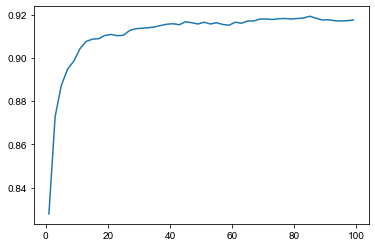

In [15]:
# 随机森林模型
score = []
for i in range(1, 100, 2):
    rfc = RandomForestClassifier(n_estimators = i,
                                n_jobs = -1,
                                random_state = 50)
    score.append(cross_val_score(rfc, X, np.array(y).flatten(), cv = 10).mean())

print(max(score), score.index(max(score))*2)
plt.plot(range(1, 100, 2), score)
plt.show()

In [16]:
clf = RandomForestClassifier(n_estimators = 84,
                                n_jobs = -1,
                                random_state = 50).fit(X_train, y_train)
result = clf.predict(X_test)
score = clf.score(X_test, y_test)
recall = recall_score(y_test, result, average='micro')
proba = clf.predict_proba(X_test)
auc = roc_auc_score(np.array(y_test).flatten(), np.array(pd.DataFrame(proba).apply(lambda x: x.max(), axis = 1).tolist()))
print("%s 's testing accuracy %f, recall is %f', auc is %f" % ('knn', score, recall, auc))

/Users/chenzhao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


knn 's testing accuracy 0.916538, recall is 0.916538', auc is 0.517736


In [17]:
# SVM模型
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    clf = SVC(kernel = kernel,
             gamma = 'auto',
             degree = 1,
             cache_size = 5000).fit(X_train, y_train)
    result = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    recall = recall_score(y_test, result)
    auc = roc_auc_score(y_test, clf.decision_function(X_test))
    print("%s 's testing accuracy %f, recall is %f', auc is %f" % (kernel, score, recall, auc))

/Users/chenzhao/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


linear 's testing accuracy 0.825000, recall is 0.765613', auc is 0.902541


/Users/chenzhao/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


poly 's testing accuracy 0.825769, recall is 0.764842', auc is 0.902819


/Users/chenzhao/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


rbf 's testing accuracy 0.880385, recall is 0.876638', auc is 0.939058


/Users/chenzhao/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sigmoid 's testing accuracy 0.711923, recall is 0.700077', auc is 0.766969


### 总结
- 综上：
- knn和随机森林的准确率和recall都较高但是auc却很低
- 而svm模型中的rbf参数所在的模型对于准确率recall和auc都较高，所以该模型采用svm较合适